In [73]:
def fix_quote_type(sent):    
    CLEANR = re.compile('<.*?>')
    def cleanhtml(raw_html):
        cleantext = re.sub(CLEANR, '', raw_html)
        return cleantext
    
    def normalize(text):
        text = '' if pd.isnull(text) else text
        text = re.sub('\\s+', ' ', text)
        return cleanhtml(unidecode(text).strip())
    
    quote_type_mapper = {
        '': 'No Quote',
        'BACKGROUND': 'Background/Narrative',
        'NARRATIVE': 'Background/Narrative',
        'PUBLIC SPEECH, NOT TO JOURNO': 'Statement/Public Speech',
        'STATEMENT': 'Statement/Public Speech',
        'COMMUNICATION, NOT TO JOURNO': 'Email/Social Media Post',
        'LAWSUIT': 'Court Proceeding',
        'TWEET': 'Email/Social Media Post',
        'SOCIAL MEDIA POST': 'Email/Social Media Post',        
        'PROPOSAL': 'Proposal/Order/Law',
        'Other: LAWSUIT': 'Court Proceeding',
        'Other: Evaluation': 'Quote',
        'Other: DIRECT OBSERVATION': 'Direct Observation',
        'Other: Campaign filing': 'Published Work/Press Report',
        'Other: VOTE/POLL': 'Vote/Poll',
        'Other: PROPOSAL': 'Proposal/Order/Law',
        'Other: Campaign Filing': 'Published Work/Press Report',
        'Other: Data analysis': 'Direct Observation',
        'Other: Analysis': 'Direct Observation',
        'Other: LAW': 'Proposal/Order/Law',
        'Other: Investigation': 'Direct Observation',
        'Other: Database': 'Published Work/Press Report',
        'Other: Data Analysis': 'Direct Observation',
        'DOCUMENT': 'Published Work/Press Report',
        'PRESS REPORT': 'Published Work/Press Report',
        'PUBLISHED WORK': 'Published Work/Press Report',        
    }
    other_cats = {
        'Other: Cannot Determine': 'Other',
        'Quote': 'Other', 
        'VOTE/POLL': 'Other',
        'Vote/Poll':'Other',
        'Declined Comment': 'Other',
        'PRICE SIGNAL': 'Other',
        'DECLINED COMMENT': 'Other'
    }
    q = sent.get('quote_type', '')
    q = quote_type_mapper.get(q, q)
    q = other_cats.get(q, q )
    if (q == 'QUOTE'):
        if ('\"' in normalize(sent['sent'])):
            return 'Indirect Quote'
        else:
            return 'Direct Quote'
    return q.title() if pd.notnull(q) else q

In [74]:
from unidecode import unidecode
import jsonlines
from tqdm import tqdm

import sys
sys.path.insert(0, '../../source-exploration/scripts/')
import prep_data_stage2 as p 

import pandas as pd
import re
import glob

CLEANR = re.compile('<.*?>')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

def process_one_doc(one_doc_df):
    output_data = []
    one_doc_df['sent'] = one_doc_df['sent'].apply(cleanhtml)
    one_doc_df['label'] = (
        one_doc_df
             .fillna('')
             .apply(lambda x: (unidecode(x['sent']) != '"') and (len(x['sent']) > 2), axis=1)
    )
    return one_doc_df

input_files = glob.glob('../../source-exploration/app/data/input_data/*/*')
checked_files = glob.glob('../../source-exploration/app/data/checked_data_affil-role/*/*')
alex_annotated_files = glob.glob('../../source-exploration/app/data/output_data_affil-role/*/*')
james_annotated_files = glob.glob('../../source-exploration/app/data/output_data_affil-role_james/*')

# dedup
alex_annotated_set = set(map(lambda x: x.split('/')[-1], alex_annotated_files))
james_annotated_files = list(filter(lambda x: x.split('/')[-1] not in alex_annotated_set, james_annotated_files))

all_sources = p.get_all_annot_input_file_pairs(
    alex_annotated_files + james_annotated_files, checked_files, input_files
)

In [75]:
all_sources_df = pd.concat(all_sources).pipe(process_one_doc)

In [76]:
all_sources_df['quote_type'] = all_sources_df.apply(fix_quote_type, axis=1)

# Model with SKLearn

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

### Quote type

In [13]:
lr_pipe = Pipeline([
    ('cv', CountVectorizer(min_df=.001, max_df=.4, stop_words='english')),
    ('lr', LogisticRegression(max_iter=5000))
])

In [22]:
quote_type_df = all_sources_df.loc[lambda df: df['quote_type'] != 'No Quote'].dropna()  #.groupby('doc_id')[['sent', 'quote_type']]

In [24]:
train_docs, test_docs = train_test_split(
    quote_type_df['doc_id'].drop_duplicates().tolist(), test_size=.1)

In [25]:
train_df = quote_type_df.loc[lambda df: df['doc_id'].isin(train_docs)]
test_df = quote_type_df.loc[lambda df: df['doc_id'].isin(test_docs)]

In [26]:
lr_pipe.fit(X=train_df['sent'], y=train_df['quote_type'])

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.4, min_df=0.001,
                                 stop_words='english')),
                ('lr', LogisticRegression(max_iter=5000))])

In [27]:
y_pred = lr_pipe.predict(test_df['sent'])

In [30]:
f1_score(y_pred, test_df['quote_type'], average='macro')

0.29278373388399637

In [32]:
l = test_df['quote_type'].drop_duplicates().sort_values()
c_matrix = confusion_matrix(
    test_df['quote_type'], y_pred, labels=l
)

In [35]:
c_mat_df = pd.DataFrame(c_matrix, index=l, columns=l)

In [42]:
c_mat_df.sum(axis=1)

quote_type
Background/Narrative           183
Court Proceeding                 3
Direct Observation               7
Direct Quote                   406
Email/Social Media Post         67
Indirect Quote                 330
Other                           30
Proposal/Order/Law              56
Published Work/Press Report    135
Statement/Public Speech        231
dtype: int64

<Axes: xlabel='quote_type', ylabel='quote_type'>

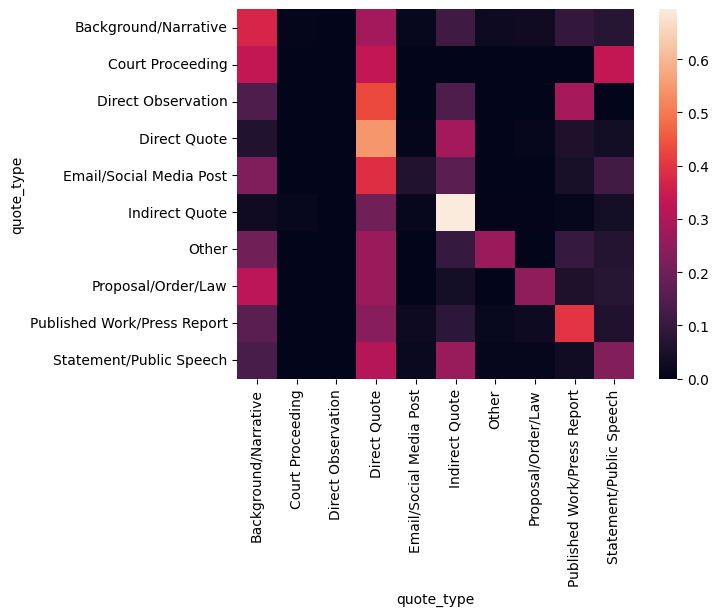

In [43]:
sns.heatmap(c_mat_df.divide(c_mat_df.sum(axis=1), axis=0))

In [84]:
quote_type_grouped = (
    all_sources_df
        .dropna()    
        .groupby('doc_id')[['sent', 'quote_type']]
        .aggregate(list)
        .reset_index()
        .assign(split=lambda df: df['doc_id'].apply(lambda x: 'train' if x in train_docs else 'test' ))            
)

In [85]:
quote_type_grouped.to_json('../modeling/quote-type-modeling/data/quote-type-data.jsonl', orient='records', lines=True)

### Source type

In [15]:
doc_split_df = pd.read_json(
    '../modeling/quote-type-modeling/data/quote-type-data.jsonl',
    orient='records',
    lines=True
)[['doc_id', 'split']]

In [16]:
source_type_mapper = {
    'Other: Vote/Poll': 'Vote/Poll',
    'Other: Database': 'Database',
    'Other: author': 'Named Individual',
}

source_type_grouped = (
    all_sources_df
        .groupby(['doc_id', 'head'])[['sent', 'source_type']]
        .aggregate(list)
        .assign(sent=lambda df: df['sent'].str.join(' '))
        .assign(source_type=lambda df: df['source_type'].apply(lambda x: list(filter(lambda x: x != '', set(x)))))
        .loc[lambda df: df['source_type'].str.len() == 1]
        .assign(source_type=lambda df: df['source_type'].str.get(0).apply(lambda x: source_type_mapper.get(x, x)))
)

source_type_grouped = (
    source_type_grouped
        .reset_index()
        .assign(doc_id=lambda df: df['doc_id'].astype(int))
        .merge(doc_split_df, left_on='doc_id', right_on='doc_id')
)

In [17]:
train_df = source_type_grouped.loc[lambda df: df['split'] == 'train']
test_df = source_type_grouped.loc[lambda df: df['split'] == 'test']

lr_pipe.fit(train_df['sent'], train_df['source_type'])
y_pred = lr_pipe.predict(test_df['sent'])
f1_score(test_df['source_type'], y_pred, average='macro')

0.39306116573626065

In [18]:
train_df['source_type'].value_counts()

source_type
Named Individual      2021
Named Group            770
Unnamed Group          741
Report/Document        287
Unnamed Individual     160
Vote/Poll               54
Database                12
Cannot Determine        11
Name: count, dtype: int64

In [37]:
(source_type_grouped
     .rename(columns={'source_type': 'label'})
     .to_csv('../modeling/source-type-modeling/data/source-type-training-df.csv')
)

# Affiliation

In [19]:
affiliation_mapper = {
    'Other: Mr. Clinton': 'Government',
    'Named Individual': 'Government',
    'Other: author': 'Cannot Determine'
}


affiliation_grouped = (
    all_sources_df
        .groupby(['doc_id', 'head'])[['sent', 'affiliation']]
        .aggregate(list)
        .assign(sent=lambda df: df['sent'].str.join(' '))
        .assign(affiliation=lambda df: df['affiliation'].apply(lambda x: list(filter(lambda x: x != '', set(x)))))
        .loc[lambda df: df['affiliation'].str.len() == 1]
        .assign(affiliation=lambda df: df['affiliation'].str.get(0).apply(lambda x: affiliation_mapper.get(x, x)))
)

affiliation_grouped = (
    affiliation_grouped
        .reset_index()
        .assign(doc_id=lambda df: df['doc_id'].astype(int))
        .merge(doc_split_df, left_on='doc_id', right_on='doc_id')
)

In [72]:
train_df = affiliation_grouped.loc[lambda df: df['split'] == 'train']
test_df = affiliation_grouped.loc[lambda df: df['split'] == 'test']

lr_pipe.fit(train_df['sent'], train_df['affiliation'])
y_pred = lr_pipe.predict(test_df['sent'])
f1_score(test_df['affiliation'], y_pred, average='macro')

0.3942643549771071

In [70]:
(
    affiliation_grouped
        .rename(columns={'affiliation': 'label'})
        .to_csv('../modeling/source-type-modeling/data/affiliation-training-df.csv')
)

# Role

In [40]:
role_mapper = {
    'Other: Mr. Clinton': 'Government',
    'Named Individual': 'Government',
    'Other: author': 'Cannot Determine'
}


role_grouped = (
    all_sources_df
        .groupby(['doc_id', 'head'])[['sent', 'role']]
        .aggregate(list)
        .assign(sent=lambda df: df['sent'].str.join(' '))
        .assign(role=lambda df: df['role'].apply(lambda x: list(filter(lambda x: x != '', set(x)))))
        .loc[lambda df: df['role'].str.len() == 1]
        .assign(role=lambda df: df['role'].str.get(0).apply(lambda x: role_mapper.get(x, x)))
)

role_grouped = (
    role_grouped
        .reset_index()
        .assign(doc_id=lambda df: df['doc_id'].astype(int))
        .merge(doc_split_df, left_on='doc_id', right_on='doc_id')
)

In [41]:
train_df = role_grouped.loc[lambda df: df['split'] == 'train']
test_df = role_grouped.loc[lambda df: df['split'] == 'test']

lr_pipe.fit(train_df['sent'], train_df['role'])
y_pred = lr_pipe.predict(test_df['sent'])
f1_score(test_df['role'], y_pred, average='macro')

0.5078362104954995

In [44]:
(
    role_grouped
        .rename(columns={'role': 'label'})
        .to_csv('../modeling/source-type-modeling/data/role-training-df.csv')
)

In [49]:
{v:i for i, v in enumerate(list(set(role_grouped['role'])))}

{'Decision Maker': 0,
 'Cannot Determine': 1,
 'Participant': 2,
 'Informational': 3,
 'Representative': 4}

In [52]:
{v:i for i, v in enumerate(list(set(affiliation_grouped['affiliation'])))} 

{'Witness': 0,
 'Actor': 1,
 'Academic': 2,
 'Cannot Determine': 3,
 'Political Group': 4,
 'Other Group': 5,
 'Religious Group': 6,
 'NGO': 7,
 'Victim': 8,
 'Media': 9,
 'Industry Group': 10,
 'Government': 11,
 'Union': 12,
 'Corporate': 13}

In [54]:
{v:i for i, v in enumerate(list(set(source_type_grouped['source_type'])))} 

{'Cannot Determine': 0,
 'Report/Document': 1,
 'Named Individual': 2,
 'Unnamed Individual': 3,
 'Database': 4,
 'Unnamed Group': 5,
 'Named Group': 6,
 'Vote/Poll': 7}

In [57]:
from transformers import AutoTokenizer

In [60]:
tok = AutoTokenizer.from_pretrained('roberta-base')

In [61]:
tok.pad_token_id

1

# Test loading models

In [86]:
# from transformers import AutoModel
import sys

In [93]:
sys.path.insert(0, '../modeling/quote-type-modeling/src')
from sentence_model import SentenceClassificationModel as QuoteTypeSentenceModel

In [5]:
import sys
sys.path.insert(0, '../../source-exploration/tasks/quote_attribution/other_platforms/span-detection-approaches/')
from qa_model import QAModel

In [92]:
quote_type_model = SentenceClassificationModel.from_pretrained('alex2awesome/quote-type-sentence-model')